In [ ]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *

In [3]:
folds = get_leave_one_out_cv_ids_for_ekyn()
criterion = torch.nn.CrossEntropyLoss()
all_metrics = pd.DataFrame()
all_stats = pd.DataFrame()
stage_propotions = pd.DataFrame()
recall_cm = torch.zeros((3,3))
precision_cm = torch.zeros((3,3))
for i,(train_ids,test_ids) in enumerate(folds):
    for condition in ['Vehicle','PF']:
        X,y = load_eeg_label_pair(id=test_ids[0],condition=condition)
        testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
        model = Gandalf()
        model.load_state_dict(torch.load(f=f'../models/gandalfs/gandalf_{i}/best_model.pt',map_location='cpu'))
        model.to(DEVICE)
        loss,metrics,y_true,y_pred,logits = evaluate(testloader,model,criterion,DEVICE)
        recall_cm += confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true')
        precision_cm += confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred')
        all_metrics = pd.concat([all_metrics,pd.Series(metrics,name=f'{i}')],axis=1)
        stage_propotions = pd.concat([stage_propotions,pd.Series((torch.bincount(y_pred.long())/8640).tolist()+['Predicted'],name=f'{i}')],axis=1)
        stage_propotions = pd.concat([stage_propotions,pd.Series((torch.bincount(y_true.long())/8640).tolist()+['Reference'],name=f'{i}')],axis=1)
        df = pd.DataFrame(y_true)
        df.loc[df[0] == 2,0] = 'W'
        df.loc[df[0] == 1,0] = 'S'
        df.loc[df[0] == 0,0] = 'P'
        stats = get_bout_statistics_for_predictions(df[0]).reset_index().melt(id_vars='index')
        stats['type'] = 'Reference'
        all_stats = pd.concat([all_stats,stats],axis=1)
        df = pd.DataFrame(y_pred)
        df.loc[df[0] == 2,0] = 'W'
        df.loc[df[0] == 1,0] = 'S'
        df.loc[df[0] == 0,0] = 'P'
        stats = get_bout_statistics_for_predictions(df[0]).reset_index().melt(id_vars='index')
        stats['type'] = 'Predicted'
        all_stats = pd.concat([all_stats,stats],axis=1)


  0%|          | 0/270 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 270/270 [00:10<00:00, 25.68it/s]


In [13]:
with torch.no_grad():
    y_true = torch.Tensor()
    y_pred = torch.Tensor()
    y_logits = torch.Tensor()
    y_features = torch.Tensor()
    loss_total = 0
    for (Xi,yi) in tqdm(testloader):
        y_true = torch.cat([y_true,yi.argmax(axis=1)])

        Xi,yi = Xi.to(DEVICE),yi.to(DEVICE)
        logits = model(Xi)
        loss = criterion(logits,yi)
        loss_total += loss.item()
        
        y_logits = torch.cat([y_logits,torch.softmax(logits,dim=1).detach().cpu()])
        y_pred = torch.cat([y_pred,torch.softmax(logits,dim=1).argmax(axis=1).detach().cpu()])
        y_features = torch.cat([y_features,model(Xi,classification=False).detach().cpu()])

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(init='pca')
X = tsne.fit_transform(y_features)
tsne_df = pd.DataFrame(X)
tsne_df['y'] = y_true
tsne_df = tsne_df.sort_values(by='y')
tsne_df.loc[tsne_df['y'] == 2,'y'] = 'W'
tsne_df.loc[tsne_df['y'] == 1,'y'] = 'S'
tsne_df.loc[tsne_df['y'] == 0,'y'] = 'P'

NameError: name 'tsne_df' is not defined

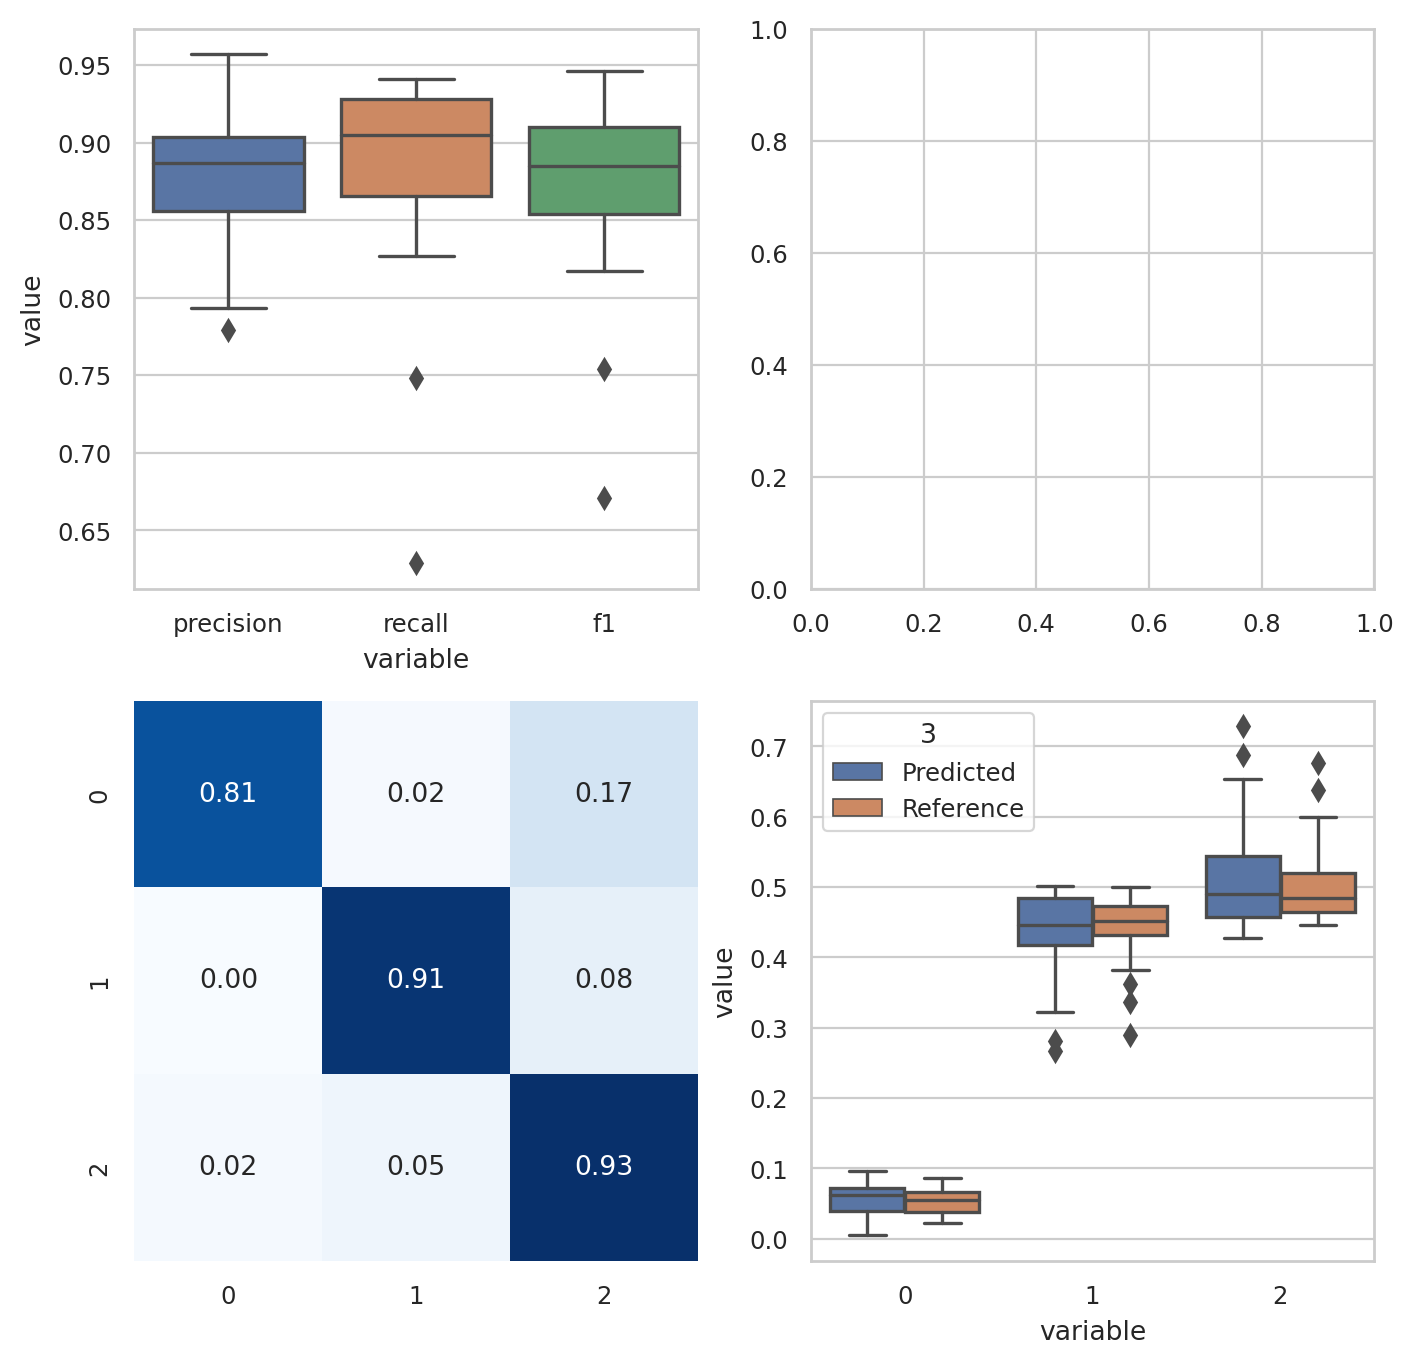

In [12]:
import seaborn as sns
sns.set_theme('paper')
sns.set_style('whitegrid')
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(8,8),dpi=200)
sns.boxplot(data=stage_propotions.T.melt(id_vars=3),x='variable',y='value',hue=3,ax=axes[1,1])
sns.boxplot(data=all_metrics.T.melt(),y='value',x='variable',ax=axes[0,0])
sns.heatmap(recall_cm/32,annot=True,fmt='.2f',cbar=False,cmap='Blues',ax=axes[1,0])
sns.scatterplot(data=tsne_df,x=0,y=1,hue='y',s=8,ax=axes[0,1])

axes[0,0].set_ylim(.5,1)
axes[1,1].set_ylim(-.05,1)
axes[0,0].set_ylabel('Score')
axes[0,0].set_xlabel('Metric (averaged over n=16 folds)')
axes[1,0].set_xticklabels(labels=['P','S','W'])
axes[1,0].set_yticklabels(labels=['P','S','W'])
axes[1,1].set_xticklabels(labels=['P','S','W'])
axes[0,1].set_xlabel('t-SNE embedding of spatiotemporal feature maps')
axes[0,1].set_ylabel('')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Reference')
axes[1,1].set_xlabel('Stage')
axes[1,1].set(ylabel='Proportion of total recording time')
axes[0,0].legend()
axes[1,1].legend()
axes[0,1].legend()
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
plt.margins(x=0,y=0)
plt.savefig('grid.svg',bbox_inches='tight')

In [ ]:
all_stats = pd.DataFrame(all_stats.to_numpy().reshape(-1,4))

In [ ]:
all_stats = pd.DataFrame(all_stats.to_numpy().reshape(-1,8))
all_stats

In [ ]:
all_stats[all_stats[0] == 'total'] 

In [ ]:
all_stats[2] = all_stats[2].astype(float)
all_stats[6] = all_stats[6].astype(float)
all_stats = all_stats.rename({2:'x',6:'y'},axis=1)

In [ ]:
import seaborn as sns
sns.set_theme('paper')
sns.set_style('whitegrid')
fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(9,9),dpi=200)

axes[0,0].set_title('Total Bout Duration')
axes[0,1].set_title('Average Bout Duration')
axes[0,2].set_title('Number of Bouts')
sns.regplot(data=all_stats[(all_stats[0] == 'total') & (all_stats[1] == 'P')],x='x',y='y',ax=axes[0,0])
axes[0,0].set_xlim([0,150])
axes[0,0].set_ylim([0,150])
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Reference (paradoxical)')

sns.regplot(data=all_stats[(all_stats[0] == 'total') & (all_stats[1] == 'S')],x='x',y='y',ax=axes[0,1])
axes[0,1].set_xlim([300,900])
axes[0,1].set_ylim([300,900])
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')

sns.regplot(data=all_stats[(all_stats[0] == 'total') & (all_stats[1] == 'W')],x='x',y='y',ax=axes[0,2])
axes[0,2].set_xlim([500,1200])
axes[0,2].set_ylim([500,1200])
axes[0,2].set_xlabel('')
axes[0,2].set_ylabel('')

sns.regplot(data=all_stats[(all_stats[0] == 'average') & (all_stats[1] == 'P')],x='x',y='y',ax=axes[1,0])
axes[1,0].set_xlim([0,150])
axes[1,0].set_ylim([0,150])
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Reference (slow wave)')

sns.regplot(data=all_stats[(all_stats[0] == 'average') & (all_stats[1] == 'S')],x='x',y='y',ax=axes[1,1])
axes[1,1].set_xlim([50,350])
axes[1,1].set_ylim([50,350])
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')

sns.regplot(data=all_stats[(all_stats[0] == 'average') & (all_stats[1] == 'W')],x='x',y='y',ax=axes[1,2])
axes[1,2].set_xlim([100,500])
axes[1,2].set_ylim([100,500])
axes[1,2].set_xlabel('')
axes[1,2].set_ylabel('')

sns.regplot(data=all_stats[(all_stats[0] == 'counts') & (all_stats[1] == 'P')],x='x',y='y',ax=axes[2,0])
axes[2,0].set_xlim([0,160])
axes[2,0].set_ylim([0,160])
axes[2,0].set_xlabel('Predicted')
axes[2,0].set_ylabel('Reference (wakefulness)')

sns.regplot(data=all_stats[(all_stats[0] == 'counts') & (all_stats[1] == 'S')],x='x',y='y',ax=axes[2,1])
axes[2,1].set_xlim([100,400])
axes[2,1].set_ylim([100,400])
axes[2,1].set_xlabel('Predicted')
axes[2,1].set_ylabel('')

sns.regplot(data=all_stats[(all_stats[0] == 'counts') & (all_stats[1] == 'W')],x='x',y='y',ax=axes[2,2])
axes[2,2].set_xlim([100,400])
axes[2,2].set_ylim([100,400])
axes[2,2].set_xlabel('Predicted')
axes[2,2].set_ylabel('')

plt.margins(x=0,y=0)
plt.savefig('reg.svg',bbox_inches='tight')